# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import gaussian_kde
import os
import matplotlib.cm as cm

sns.set_context("talk")

# Read in and clean mySAS data

In [2]:
os.chdir("../..")

Lt_file = 'mysasData/06122025/LT_LOG.txt'

# Explicit header that matches your logger columns
colnames = ["Time", "Sensor", "415", "445", "480", "515", "555", "590", "630", "680", "930", "Clear", "ASTEP", "ATIME", "GAIN", "Voltage"]

# Read the file without a header row, then assign proper column names
my_LT = pd.read_csv(Lt_file, header=None, names=colnames)

# Check it worked
print(f"Rows before filtering: {len(my_LT)}")
my_LT.head()


Rows before filtering: 1039


Time Sensor  415  445  480  515  555  590  630  680  930  \
0  2025-06-10 22:36:07     Lt  159  276  468  616  725  586  567  437  219   
1  2025-06-10 22:36:09     Lt  164  285  481  629  781  652  650  517  311   
2  2025-06-10 22:36:12     Lt  161  281  474  623  736  596  583  444  212   
3  2025-06-10 22:36:14     Lt  155  269  460  605  788  654  648  521  249   
4  2025-06-10 22:36:17     Lt  168  294  494  648  859  738  756  632  369   

   Clear  ASTEP  ATIME  GAIN  Voltage  
0   2001   1000    255     5     0.28  
1   2303   1000    255     5     0.28  
2   2021   1000    255     5     0.27  
3   2174   1000    255     5     0.28  
4   2570   1000    255     5     0.27

In [3]:
# Set up output dir
output_dir = "comparisonOutputs/L1BQC/LT/"

## Convert Time

In [4]:
# Parse Time column, coerce bad entries to NaN
my_LT['Time'] = pd.to_datetime(my_LT['Time'], errors='coerce')

# Drop rows where Time is NaN (e.g., 'Error reading AS7341')
my_LT = my_LT.dropna(subset=['Time'])

# Correct deployment time (was mistakenly set to June 11)
actual_start = pd.Timestamp('2025-06-12 15:59:26')  # <-- updated date
simulated_start = my_LT['Time'].iloc[0]

# Compute and apply offset
time_offset = actual_start - simulated_start
my_LT['Time_UTC'] = my_LT['Time'] + time_offset
my_LT.head()

Time Sensor  415  445  480  515  555  590  630  680  930  \
0 2025-06-10 22:36:07     Lt  159  276  468  616  725  586  567  437  219   
1 2025-06-10 22:36:09     Lt  164  285  481  629  781  652  650  517  311   
2 2025-06-10 22:36:12     Lt  161  281  474  623  736  596  583  444  212   
3 2025-06-10 22:36:14     Lt  155  269  460  605  788  654  648  521  249   
4 2025-06-10 22:36:17     Lt  168  294  494  648  859  738  756  632  369   

   Clear  ASTEP  ATIME  GAIN  Voltage            Time_UTC  
0   2001   1000    255     5     0.28 2025-06-12 15:59:26  
1   2303   1000    255     5     0.28 2025-06-12 15:59:28  
2   2021   1000    255     5     0.27 2025-06-12 15:59:31  
3   2174   1000    255     5     0.28 2025-06-12 15:59:33  
4   2570   1000    255     5     0.27 2025-06-12 15:59:36

## Convert counts for gain and integration

In [5]:
# Compute T_int in microseconds
my_LT['Tint_us'] = (my_LT['ATIME'] + 1) * my_LT['ASTEP'] * 2.78  # µs

# Map GAIN enum to multiplier
gain_enum_to_mult = {
    0: 0.5, 1: 1, 2: 2, 3: 4,
    4: 8, 5: 16, 6: 32, 7: 64,
    8: 128, 9: 256
}
my_LT['GAIN_MULT'] = my_LT['GAIN'].map(gain_enum_to_mult)

# Compute correction factor
my_LT['CORRECTION'] = my_LT['GAIN_MULT'] * my_LT['Tint_us']


In [6]:
# Define spectral channels
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Apply correction to each spectral channel
corrected_data = my_LT[spectral_channels].div(my_LT['CORRECTION'], axis=0)

# Create new DataFrame with Time_UTC and corrected values
my_LT_corrected = pd.concat([my_LT['Time_UTC'], corrected_data], axis=1)

# Rename columns to indicate correction
my_LT_corrected.columns = ['Time_UTC'] + [f"{ch}_corr" for ch in spectral_channels]

## Remove first 2 min and last 2 min of data

In [7]:
# Define time range
start_time = my_LT_corrected['Time_UTC'].min()
end_time = my_LT_corrected['Time_UTC'].max()

cutoff_start = start_time + pd.Timedelta(minutes=10)
cutoff_end = end_time - pd.Timedelta(minutes=2)

# Trim to middle section
my_LT_trimmed = my_LT_corrected[
    (my_LT_corrected['Time_UTC'] > cutoff_start) &
    (my_LT_corrected['Time_UTC'] < cutoff_end)
].copy()
print(f"Remaining rows after filtering: {len(my_LT_trimmed)}")

Remaining rows after filtering: 747


In [8]:
# cutoff_start = pd.Timestamp('2025-06-12 16:24:00')
# cutoff_end   = pd.Timestamp('2025-06-12 16:35:00')

# my_LT_trimmed = my_LT_corrected[
#     (my_LT_corrected['Time_UTC'] >= cutoff_start) &
#     (my_LT_corrected['Time_UTC'] <= cutoff_end)
# ].copy()

# print(f"Remaining rows after filtering: {len(my_LT_trimmed)}")


## Remove any oversaturation

In [9]:
# Define spectral channels again
spectral_channels = ['415', '445', '480', '515', '555', '590', '630', '680']

# Find rows where any of the spectral bands hit saturation (65535)
saturated_mask = (my_LT[spectral_channels] >= 65535).any(axis=1)

# Apply the same time filter to get valid timestamps
valid_times = my_LT_trimmed['Time_UTC']

# Create a filtered version of the saturation mask for only the rows in my_LT_trimmed
saturated_times = my_LT.loc[saturated_mask, 'Time_UTC']

# Filter out saturated times
my_LT_cleaned = my_LT_trimmed[~my_LT_trimmed['Time_UTC'].isin(saturated_times)].copy()
my_LT_cleaned.head()

Time_UTC  415_corr  445_corr  480_corr  515_corr  555_corr  \
243 2025-06-12 16:09:29  0.000014  0.000024  0.000040  0.000053  0.000063   
244 2025-06-12 16:09:31  0.000015  0.000026  0.000044  0.000057  0.000065   
245 2025-06-12 16:09:34  0.000015  0.000025  0.000043  0.000055  0.000064   
246 2025-06-12 16:09:36  0.000015  0.000026  0.000043  0.000057  0.000065   
247 2025-06-12 16:09:39  0.000014  0.000025  0.000042  0.000054  0.000063   

     590_corr  630_corr  680_corr  
243  0.000050  0.000049  0.000036  
244  0.000053  0.000053  0.000041  
245  0.000051  0.000050  0.000038  
246  0.000053  0.000052  0.000041  
247  0.000051  0.000050  0.000039

In [10]:
print(f"Remaining rows after filtering: {len(my_LT_cleaned)}")

Remaining rows after filtering: 747


## Plot Logger Spectra

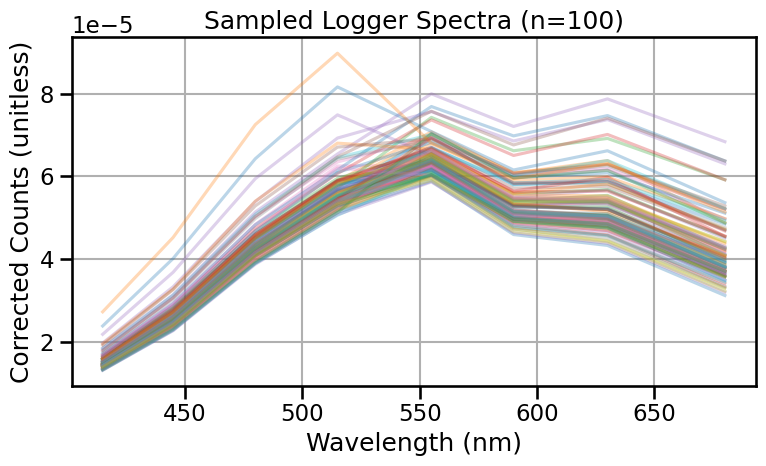

In [11]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
corr_cols = [f"{wl}_corr" for wl in wavelengths]

# Select 100 random samples
subset = my_LT_cleaned.sample(n=100, random_state=42).reset_index(drop=True)

# Plot all spectra using the same color
plt.figure(figsize=(8, 5))
for _, row in subset.iterrows():
    plt.plot(wavelengths, row[corr_cols], alpha=0.3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Corrected Counts (unitless)")
plt.title("Sampled Logger Spectra (n=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


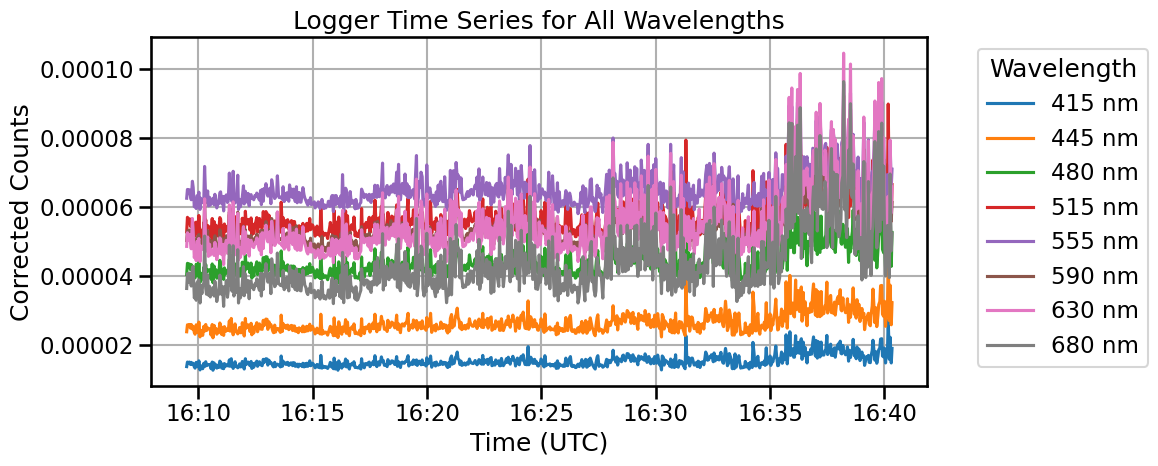

In [12]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))

for wl in wavelengths:
    col = f"{wl}_corr"
    plt.plot(my_LT_cleaned['Time_UTC'], my_LT_cleaned[col], label=f'{wl} nm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("Corrected Counts")
plt.title("Logger Time Series for All Wavelengths")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Ensure Time_UTC is datetime and set as index
my_LT_binned = my_LT_cleaned.copy()
my_LT_binned['Time_UTC'] = pd.to_datetime(my_LT_binned['Time_UTC'])
my_LT_binned.set_index('Time_UTC', inplace=True)

# Define correct column names (with _corr)
corr_cols = [f"{wl}_corr" for wl in wavelengths]

# Check available columns
print(my_LT_binned.columns)

# Resample just those columns
my_LT_1min = my_LT_binned[corr_cols].resample('1min').median().reset_index()


Index(['415_corr', '445_corr', '480_corr', '515_corr', '555_corr', '590_corr',
       '630_corr', '680_corr'],
      dtype='object')


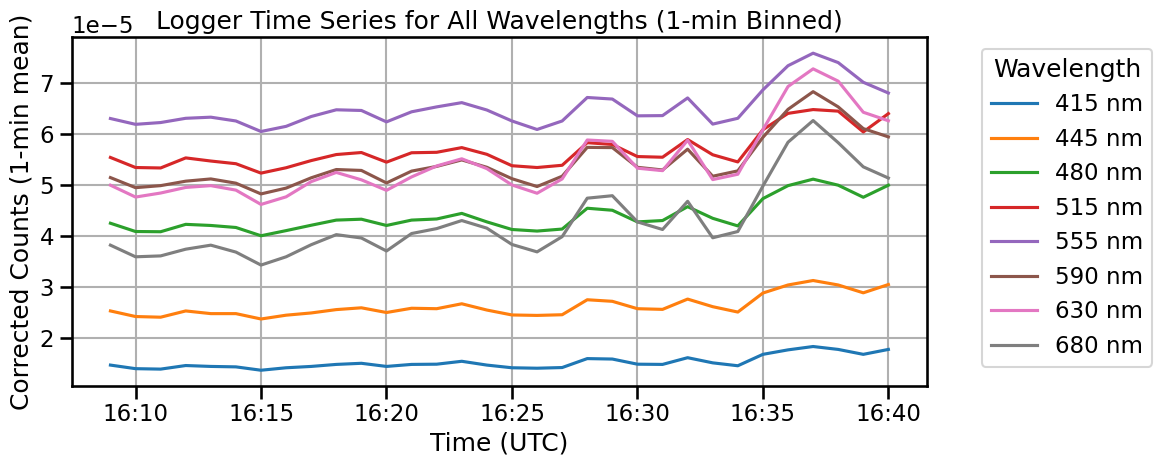

In [14]:
plt.figure(figsize=(12, 5))

for wl in wavelengths:
    col = f"{wl}_corr"
    plt.plot(my_LT_1min['Time_UTC'], my_LT_1min[col], label=f'{wl} nm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Time (UTC)")
plt.ylabel("Corrected Counts (1-min mean)")
plt.title("Logger Time Series for All Wavelengths (1-min Binned)")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Read in pySAS data

In [15]:
Lt_py_file = 'pysasData/Processed/L1BQC/pySAS_Lt_L1BQC.csv'
py_LT = pd.read_csv(Lt_py_file)
py_LT.head()

Datetag     Timetag2     350.0     353.3     356.6     359.9     363.2  \
0  2025163.0  192945506.0  0.283004  0.285673  0.283997  0.289337  0.317238   
1  2025163.0  192946830.0  0.244925  0.248080  0.246184  0.250053  0.273721   
2  2025163.0  192949291.0  0.267828  0.270319  0.267024  0.271887  0.296235   
3  2025163.0  192951698.0  0.252051  0.252563  0.250924  0.256956  0.278248   
4  2025163.0  192952929.0  0.248570  0.247985  0.246491  0.253053  0.275994   

      366.5     369.8     373.1  ...     769.1     772.4     775.7     779.0  \
0  0.347974  0.346805  0.342711  ...  0.144764  0.157892  0.164111  0.160210   
1  0.298911  0.299062  0.296432  ...  0.120504  0.129743  0.139946  0.132401   
2  0.325177  0.328498  0.323558  ...  0.141509  0.154981  0.158631  0.158462   
3  0.306407  0.308745  0.303405  ...  0.127724  0.134050  0.143478  0.137471   
4  0.301364  0.301684  0.299126  ...  0.126327  0.133749  0.142635  0.139412   

      782.3     785.6     788.9     792.2     795.5     798.8  
0  0.158866  0.156754  0.151926  0.153628  0.145996  0.147459  
1  0.131113  0.132011  0.128842  0.131339  0.126668  0.128627  
2  0.158936  0.151259  0.156257  0.155446  0.142686  0.145401  
3  0.132867  0.136947  0.134528  0.136215  0.136750  0.133510  
4  0.137668  0.136801  0.131343  0.131941  0.127540  0.126793  

[5 rows x 139 columns]

In [16]:
print(f"Rows before filtering: {len(py_LT)}")

Rows before filtering: 2414


## Convert time

In [17]:
# Safely convert Datetag
datetag_clean = py_LT['Datetag'].astype(str).str.replace('.0', '', regex=False)
year = datetag_clean.str[:4].astype(int)
doy = datetag_clean.str[4:].astype(int)
date_part = pd.to_datetime(year * 1000 + doy, format='%Y%j')

# Parse Timetag2 as HHMMSSmmm
timetag_str = py_LT['Timetag2'].astype(int).astype(str).str.zfill(9)
hours = timetag_str.str[0:2].astype(int)
minutes = timetag_str.str[2:4].astype(int)
seconds = timetag_str.str[4:6].astype(int)
milliseconds = timetag_str.str[6:9].astype(int)

# Combine date and time
py_LT['Time_UTC'] = date_part + \
    pd.to_timedelta(hours, unit='h') + \
    pd.to_timedelta(minutes, unit='m') + \
    pd.to_timedelta(seconds, unit='s') + \
    pd.to_timedelta(milliseconds, unit='ms')

# Apply timezone shift from EDT to UTC
py_LT['Time_UTC'] -= pd.Timedelta(hours=4)
py_LT.head()

Datetag     Timetag2     350.0     353.3     356.6     359.9     363.2  \
0  2025163.0  192945506.0  0.283004  0.285673  0.283997  0.289337  0.317238   
1  2025163.0  192946830.0  0.244925  0.248080  0.246184  0.250053  0.273721   
2  2025163.0  192949291.0  0.267828  0.270319  0.267024  0.271887  0.296235   
3  2025163.0  192951698.0  0.252051  0.252563  0.250924  0.256956  0.278248   
4  2025163.0  192952929.0  0.248570  0.247985  0.246491  0.253053  0.275994   

      366.5     369.8     373.1  ...     772.4     775.7     779.0     782.3  \
0  0.347974  0.346805  0.342711  ...  0.157892  0.164111  0.160210  0.158866   
1  0.298911  0.299062  0.296432  ...  0.129743  0.139946  0.132401  0.131113   
2  0.325177  0.328498  0.323558  ...  0.154981  0.158631  0.158462  0.158936   
3  0.306407  0.308745  0.303405  ...  0.134050  0.143478  0.137471  0.132867   
4  0.301364  0.301684  0.299126  ...  0.133749  0.142635  0.139412  0.137668   

      785.6     788.9     792.2     795.5     798.8                Time_UTC  
0  0.156754  0.151926  0.153628  0.145996  0.147459 2025-06-12 15:29:45.506  
1  0.132011  0.128842  0.131339  0.126668  0.128627 2025-06-12 15:29:46.830  
2  0.151259  0.156257  0.155446  0.142686  0.145401 2025-06-12 15:29:49.291  
3  0.136947  0.134528  0.136215  0.136750  0.133510 2025-06-12 15:29:51.698  
4  0.136801  0.131343  0.131941  0.127540  0.126793 2025-06-12 15:29:52.929  

[5 rows x 140 columns]

In [18]:
# Map logger wavelengths to nearest pySAS band available
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# Create list of columns to extract
pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# Subset pySAS
py_LT_visible = py_LT[pysas_columns].copy()

# Rename columns to match logger names for easy comparison
rename_columns = {'Time_UTC': 'Time_UTC'}
rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
py_LT_visible.rename(columns=rename_columns, inplace=True)

# Preview
py_LT_visible.head()


Time_UTC  415_pySAS  445_pySAS  480_pySAS  515_pySAS  \
0 2025-06-12 15:29:45.506   0.626207   0.800660   1.005941   1.070914   
1 2025-06-12 15:29:46.830   0.545739   0.709218   0.913790   0.993196   
2 2025-06-12 15:29:49.291   0.588980   0.754850   0.959695   1.031910   
3 2025-06-12 15:29:51.698   0.553723   0.717819   0.925718   1.000722   
4 2025-06-12 15:29:52.929   0.546708   0.711501   0.918118   0.993524   

   555_pySAS  590_pySAS  630_pySAS  680_pySAS  
0   1.235099   0.940396   0.564533   0.406182  
1   1.163713   0.881497   0.513251   0.365210  
2   1.198181   0.912291   0.543728   0.389239  
3   1.170165   0.889955   0.520270   0.370337  
4   1.165756   0.881519   0.513294   0.366888

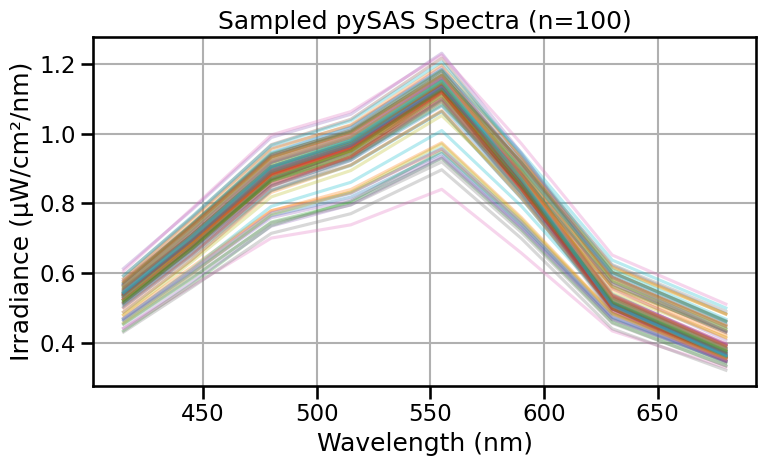

In [19]:
# Define pySAS spectral columns and corresponding wavelengths
pysas_cols = [f"{wl}_pySAS" for wl in [415, 445, 480, 515, 555, 590, 630, 680]]
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Sample 100 rows
subset_py = py_LT_visible.sample(n=100, random_state=42)

# Plot spectra
plt.figure(figsize=(8, 5))
for _, row in subset_py.iterrows():
    plt.plot(wavelengths, row[pysas_cols], alpha=0.3)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (µW/cm²/nm)")
plt.title("Sampled pySAS Spectra (n=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Match mySAS to pySAS

## Match time

In [20]:
# Round or floor pySAS timestamps to nearest second
py_LT['Time_UTC_trimmed'] = py_LT['Time_UTC'].dt.floor('s')

# Now subset using the trimmed column
start_time = my_LT_cleaned['Time_UTC'].min()
end_time = my_LT_cleaned['Time_UTC'].max()

py_LT_trimmed = py_LT[(py_LT['Time_UTC_trimmed'] >= start_time) & (py_LT['Time_UTC_trimmed'] <= end_time)].copy()

print(f"pySAS rows after time subsetting: {len(py_LT_trimmed)}")


pySAS rows after time subsetting: 669


## Match wavelengths

In [21]:
# Map logger wavelengths to nearest pySAS band available
logger_to_pysas = {
    '415': '416.0',
    '445': '445.7',
    '480': '478.7',
    '515': '515.0',
    '555': '554.6',
    '590': '590.9',
    '630': '630.5',
    '680': '680.0'
}

# Create list of columns to extract
pysas_columns = ['Time_UTC'] + list(logger_to_pysas.values())

# Subset pySAS
py_LT_visible = py_LT_trimmed[pysas_columns].copy()

# Rename columns to match logger names for easy comparison
rename_columns = {'Time_UTC': 'Time_UTC'}
rename_columns.update({v: f"{k}_pySAS" for k, v in logger_to_pysas.items()})
py_LT_visible.rename(columns=rename_columns, inplace=True)

# Preview
py_LT_visible.head()


Time_UTC  415_pySAS  445_pySAS  480_pySAS  515_pySAS  \
1225 2025-06-12 16:09:29.259   0.519443   0.671057   0.864153   0.940529   
1226 2025-06-12 16:09:33.773   0.507914   0.657019   0.847544   0.926215   
1227 2025-06-12 16:09:36.002   0.509968   0.661591   0.855910   0.935770   
1228 2025-06-12 16:09:38.233   0.519349   0.670416   0.861658   0.938822   
1229 2025-06-12 16:09:40.570   0.520423   0.671262   0.864622   0.941202   

      555_pySAS  590_pySAS  630_pySAS  680_pySAS  
1225   1.110221   0.848680   0.512852   0.373514  
1226   1.091944   0.832442   0.497602   0.356777  
1227   1.105465   0.844133   0.509888   0.371610  
1228   1.106543   0.845138   0.512846   0.372306  
1229   1.109951   0.849021   0.514865   0.374710

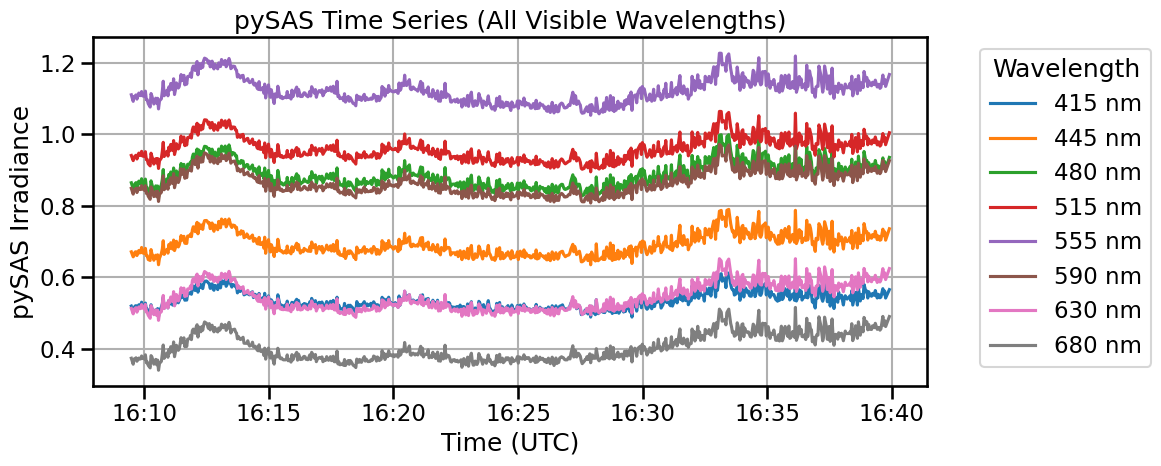

In [22]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

plt.figure(figsize=(12, 5))
for wl in wavelengths:
    plt.plot(py_LT_visible['Time_UTC'], py_LT_visible[f'{wl}_pySAS'], label=f'{wl} nm')

# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Time (UTC)")
plt.ylabel("pySAS Irradiance")
plt.title("pySAS Time Series (All Visible Wavelengths)")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Make a copy and set datetime index
py_LT_binned = py_LT_visible.copy()
py_LT_binned['Time_UTC'] = pd.to_datetime(py_LT_binned['Time_UTC'])
py_LT_binned.set_index('Time_UTC', inplace=True)

# Define column names
pysas_cols = [f"{wl}_pySAS" for wl in wavelengths]

# Resample using 1-minute median
py_LT_1min = py_LT_binned[pysas_cols].resample('1min').median().reset_index()


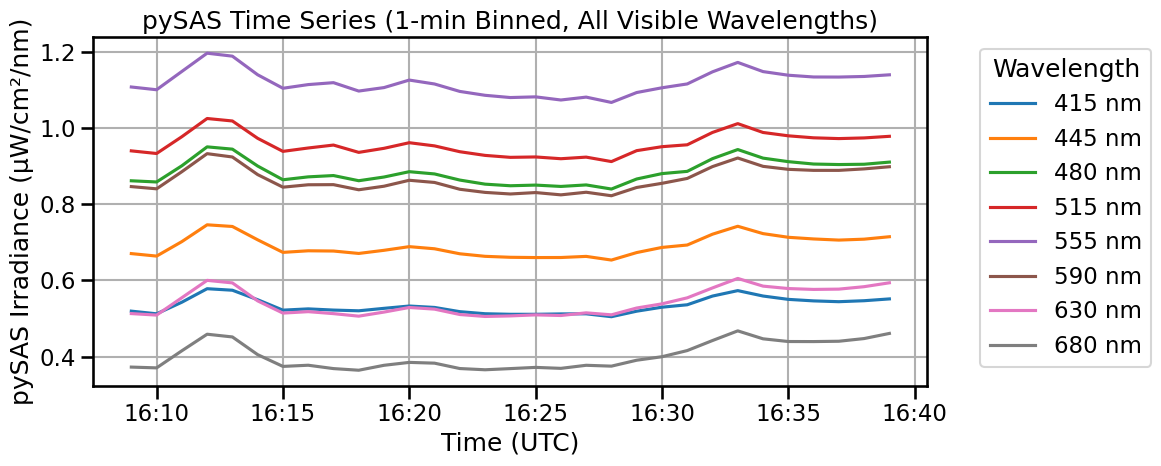

In [24]:
plt.figure(figsize=(12, 5))

for wl in wavelengths:
    col = f"{wl}_pySAS"
    plt.plot(py_LT_1min['Time_UTC'], py_LT_1min[col], label=f'{wl} nm')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel("Time (UTC)")
plt.ylabel("pySAS Irradiance (µW/cm²/nm)")
plt.title("pySAS Time Series (1-min Binned, All Visible Wavelengths)")
plt.legend(title="Wavelength", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Create Conversion factor

In [25]:
# Rename 'Time_UTC' to 'Time_UTC_rounded' in both binned DataFrames
my_LT_1min = my_LT_1min.rename(columns={'Time_UTC': 'Time_UTC_rounded'})
py_LT_1min = py_LT_1min.rename(columns={'Time_UTC': 'Time_UTC_rounded'})

# Now merge on the new 'Time_UTC_rounded' column
merged = pd.merge(
    my_LT_1min, py_LT_1min,
    on='Time_UTC_rounded', how='inner',
    suffixes=('_logger', '_pySAS')
)

merged.head()

Time_UTC_rounded  415_corr  445_corr  480_corr  515_corr  555_corr  \
0 2025-06-12 16:09:00  0.000015  0.000025  0.000043  0.000055  0.000063   
1 2025-06-12 16:10:00  0.000014  0.000024  0.000041  0.000053  0.000062   
2 2025-06-12 16:11:00  0.000014  0.000024  0.000041  0.000053  0.000062   
3 2025-06-12 16:12:00  0.000015  0.000025  0.000042  0.000055  0.000063   
4 2025-06-12 16:13:00  0.000014  0.000025  0.000042  0.000055  0.000063   

   590_corr  630_corr  680_corr  415_pySAS  445_pySAS  480_pySAS  515_pySAS  \
0  0.000051  0.000050  0.000038   0.519249   0.670416   0.861658   0.940230   
1  0.000049  0.000048  0.000036   0.512289   0.663864   0.858533   0.933321   
2  0.000050  0.000048  0.000036   0.542695   0.701901   0.901074   0.977432   
3  0.000051  0.000050  0.000037   0.578188   0.746015   0.950765   1.025251   
4  0.000051  0.000050  0.000038   0.574197   0.741646   0.944752   1.018738   

   555_pySAS  590_pySAS  630_pySAS  680_pySAS  
0   1.108000   0.846394   0.512846   0.372306  
1   1.100778   0.840531   0.508871   0.370247  
2   1.148857   0.885493   0.554526   0.415180  
3   1.196807   0.932903   0.600119   0.458655  
4   1.188983   0.924153   0.593437   0.451486

In [26]:
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
regression_results = []

for wl in wavelengths:
    logger_col = f'{wl}_corr'
    pysas_col = f'{wl}_pySAS'

    # Drop NaNs
    valid = merged[[logger_col, pysas_col]].dropna()

    x = valid[logger_col].values.reshape(-1, 1)
    y = valid[pysas_col].values

    model = LinearRegression().fit(x, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x, y)

    # Calculate RMSE
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean((y - y_pred) ** 2))

    regression_results.append({
        'Wavelength': wl,
        'Slope': slope,
        'Intercept': intercept,
        'R²': r2,
        'RMSE': rmse
    })

    # Store predictions for plotting
    valid['pred'] = y_pred
    regression_results[-1]['data'] = valid


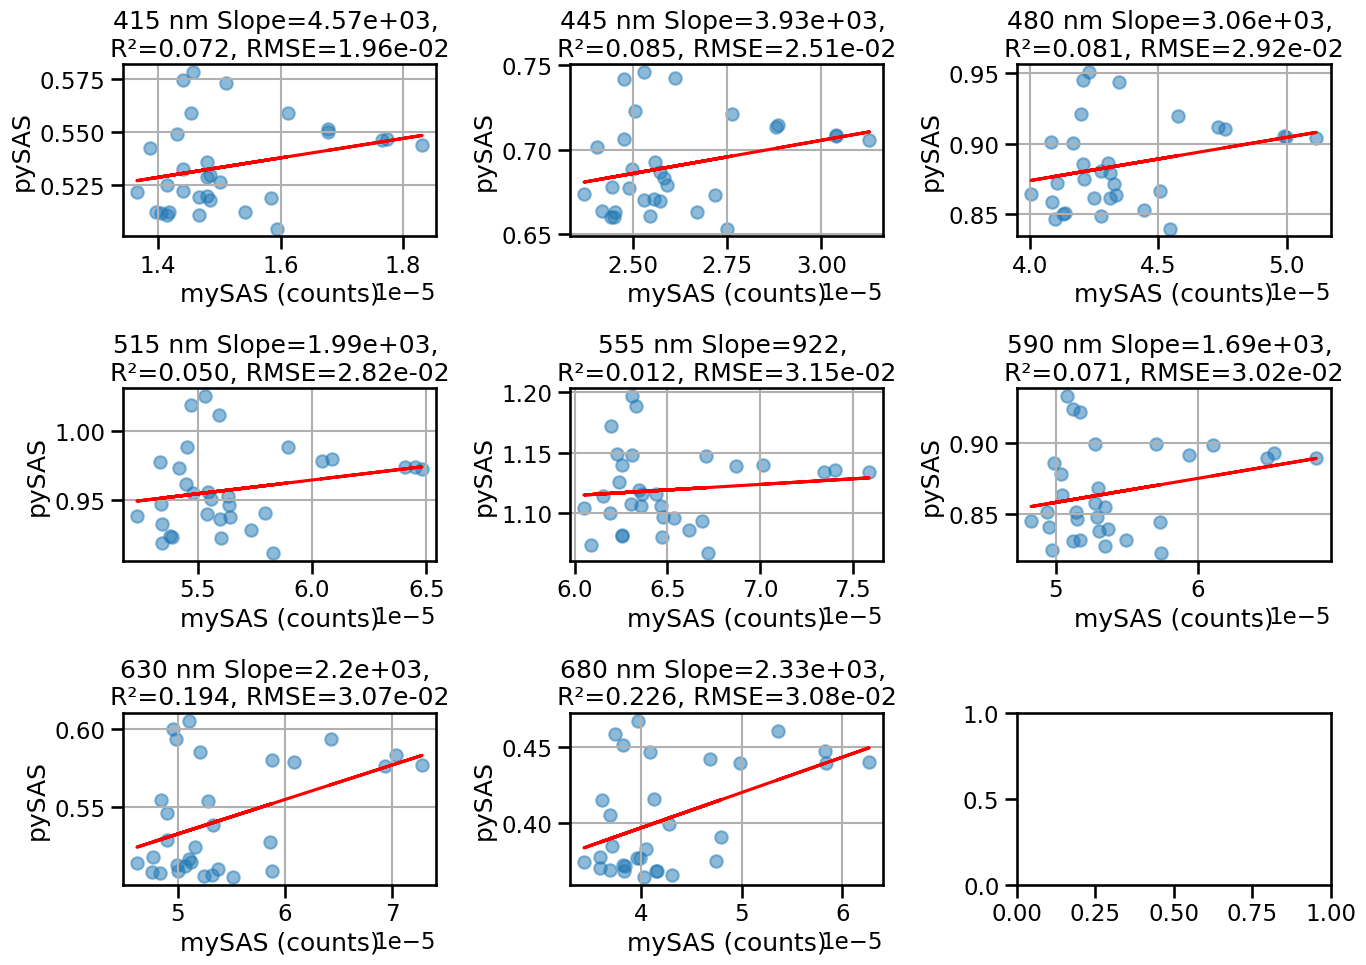

In [27]:
# Plot
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for i, res in enumerate(regression_results):
    ax = axes[i]
    data = res['data']
    wl = res['Wavelength']

    ax.scatter(data[f'{wl}_corr'], data[f'{wl}_pySAS'], alpha=0.5, label='Data')
    ax.plot(data[f'{wl}_corr'], data['pred'], color='red', label='Fit')

    # Updated title to include RMSE
    ax.set_title(
        f"{wl} nm Slope={res['Slope']:.3g}, \nR²={res['R²']:.3f}, RMSE={res['RMSE']:.2e}"
    )

    ax.set_xlabel('mySAS (counts)')
    ax.set_ylabel('pySAS')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# Create summary DataFrame from regression results
summary_df = pd.DataFrame(regression_results).drop(columns='data')

# Display
print(summary_df.to_string(index=False))

# Export regression summary to CSV
summary_df.to_csv(os.path.join(output_dir,"mySAS_pySAS_Lt_regression_summary.csv"), index=False)


 Wavelength       Slope  Intercept       R²     RMSE
        415 4567.973359   0.464765 0.071554 0.019580
        445 3931.293460   0.587696 0.085105 0.025145
        480 3058.090281   0.751593 0.080848 0.029159
        515 1987.843346   0.845513 0.050390 0.028207
        555  921.863165   1.059500 0.012145 0.031526
        590 1694.815446   0.773300 0.071469 0.030153
        630 2199.967021   0.422882 0.194111 0.030678
        680 2329.224477   0.303591 0.226348 0.030762


# Apply Conversion Factor

In [29]:
my_LT_converted = pd.DataFrame()
my_LT_converted['Time_UTC'] = my_LT_cleaned['Time_UTC']

for _, row in summary_df.iterrows():
    wl = int(row['Wavelength'])  # Convert to integer
    slope = row['Slope']
    intercept = row['Intercept']

    input_col = f"{wl}_corr"
    output_col = f"{wl}_converted"

    my_LT_converted[output_col] = my_LT_cleaned[input_col] * slope + intercept


In [30]:
my_LT_converted['Time_UTC_rounded'] = my_LT_converted['Time_UTC'].dt.round('1s')
py_LT_visible['Time_UTC_rounded'] = py_LT_visible['Time_UTC'].dt.round('1s')


In [31]:
merged_converted = pd.merge(
    my_LT_converted, py_LT_visible,
    on='Time_UTC_rounded', how='inner', suffixes=('_logger', '_pySAS')
)

merged_converted.to_csv(os.path.join(output_dir,"mySAS_pySAS_Lt_converted.csv"), index=False)

# Figures

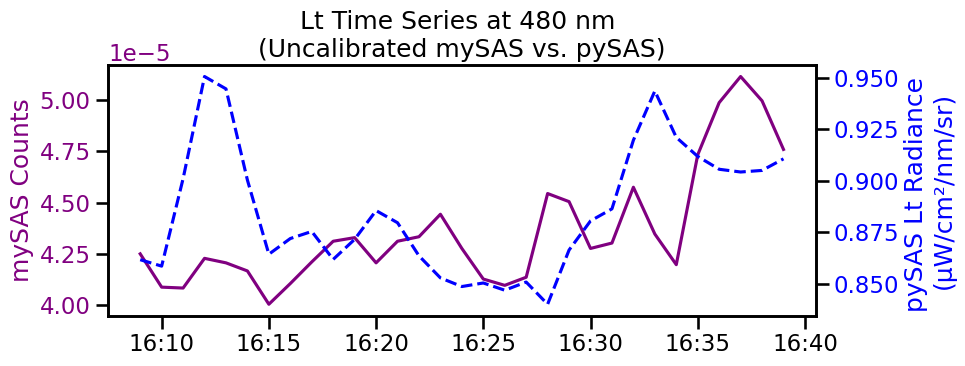

In [34]:
wl = 480  # Example wavelength

fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: raw logger counts
ax1.plot(merged['Time_UTC_rounded'], merged[f'{wl}_corr'], color='purple', label='Logger (raw)')
ax1.set_ylabel('mySAS Counts', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
#ax1.set_xlabel('Time (UTC)')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Right axis: pySAS irradiance
ax2 = ax1.twinx()
ax2.plot(merged['Time_UTC_rounded'], merged[f'{wl}_pySAS'], color='blue', linestyle='--', label='pySAS')
ax2.set_ylabel('pySAS Lt Radiance \n(µW/cm²/nm/sr)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f"Lt Time Series at {wl} nm \n(Uncalibrated mySAS vs. pySAS)")
fig.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Lt_TS_unCorr.png"), dpi=300, bbox_inches='tight')
plt.show()


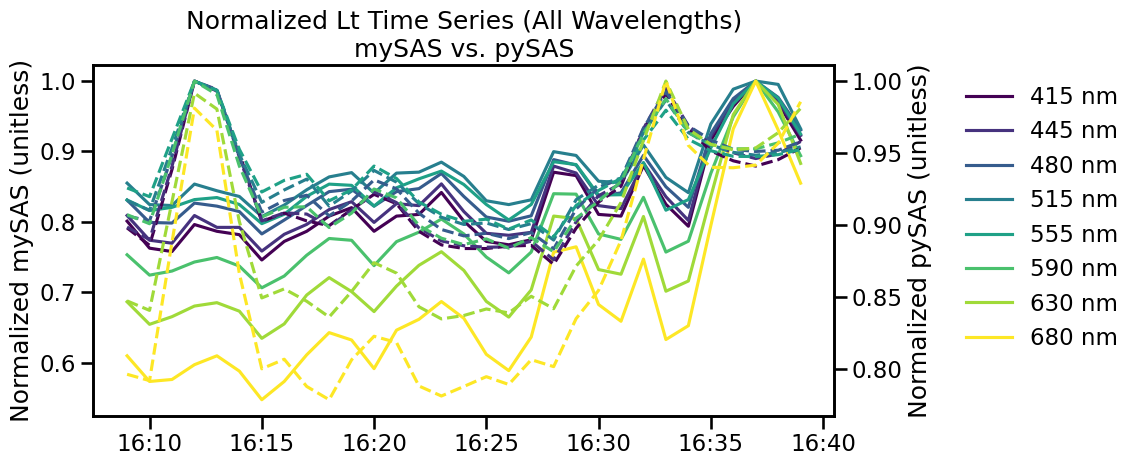

In [35]:
# Wavelengths to include
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]

# Generate a colormap for wavelength color coding
colors = cm.viridis(np.linspace(0, 1, len(wavelengths)))

# Create plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot normalized mySAS counts (left y-axis)
for wl, color in zip(wavelengths, colors):
    y_logger = merged[f'{wl}_corr'] / merged[f'{wl}_corr'].max()
    ax1.plot(merged['Time_UTC_rounded'], y_logger, color=color, label=f'{wl} nm (mySAS)')

ax1.set_ylabel('Normalized mySAS (unitless)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add second y-axis for pySAS (right y-axis)
ax2 = ax1.twinx()
for wl, color in zip(wavelengths, colors):
    y_pysas = merged[f'{wl}_pySAS'] / merged[f'{wl}_pySAS'].max()
    ax2.plot(merged['Time_UTC_rounded'], y_pysas, linestyle='--', color=color, label=f'{wl} nm (pySAS)')

ax2.set_ylabel('Normalized pySAS (unitless)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Create custom legend (one entry per wavelength)
handles = [plt.Line2D([0], [0], color=color, label=f"{wl} nm") for wl, color in zip(wavelengths, colors)]

# Legend in upper right, outside plot, no frame, 2 columns
ax1.legend(handles=handles,
           title='',
           loc='upper left',
           bbox_to_anchor=(1.15, 1),  # shift further right
           ncol=1,
           frameon=False)

plt.title("Normalized Lt Time Series (All Wavelengths)\nmySAS vs. pySAS")
plt.xticks(rotation=45)

fig.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Lt_TS_allWavelengths_normalized.png"), dpi=300, bbox_inches='tight')
plt.show()


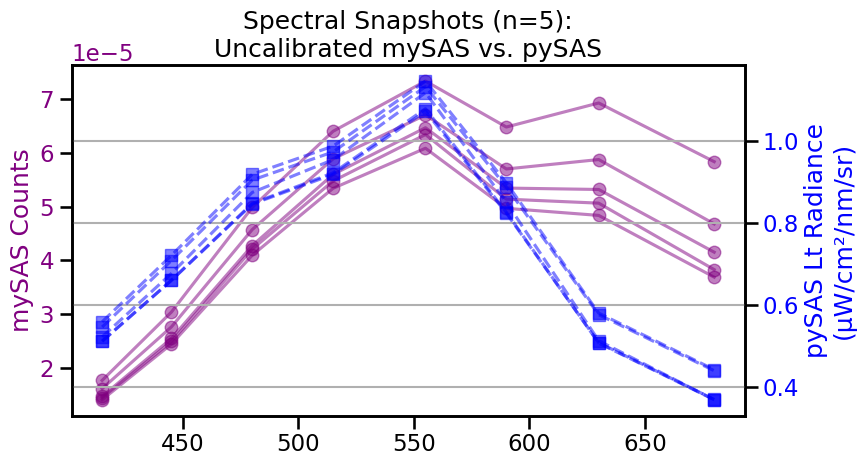

In [37]:
# Pick 5 random snapshots from merged
subset = merged.sample(n=5, random_state=42)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Plot raw mySAS counts (left y-axis)
for _, row in subset.iterrows():
    logger_vals = [row[f'{wl}_corr'] for wl in wavelengths]
    ax1.plot(wavelengths, logger_vals, color='purple', alpha=0.5, marker='o', linestyle='-')

ax1.set_ylabel("mySAS Counts", color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

# Plot pySAS irradiance (right y-axis)
ax2 = ax1.twinx()
for _, row in subset.iterrows():
    pysas_vals = [row[f'{wl}_pySAS'] for wl in wavelengths]
    ax2.plot(wavelengths, pysas_vals, color='blue', alpha=0.5, marker='s', linestyle='--')

ax2.set_ylabel("pySAS Lt Radiance\n(µW/cm²/nm/sr)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xlabel("Wavelength (nm)")
plt.title("Spectral Snapshots (n=5):\nUncalibrated mySAS vs. pySAS")
plt.grid(True)
fig.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Lt_spectra_unCorr_multi.png"), dpi=300, bbox_inches='tight')
plt.show()


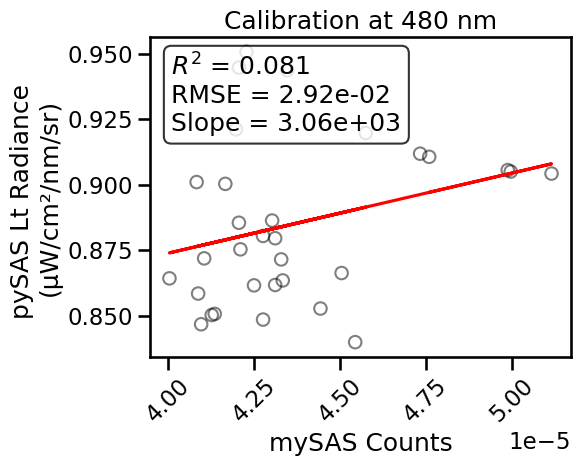

In [38]:
# Choose wavelength
wl = 480
x = merged[f'{wl}_corr'].values.reshape(-1, 1)
y = merged[f'{wl}_pySAS'].values

# Fit linear regression
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

slope = model.coef_[0]
intercept = model.intercept_
r2 = model.score(x, y)
rmse = np.sqrt(np.mean((y - y_pred) ** 2))

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(x, y, alpha=0.5, label='Data', edgecolor='k', facecolor='none')
plt.plot(x, y_pred, color='red', label='Fit')

# Annotate stats
plt.title(f"Calibration at {wl} nm")
plt.xlabel("mySAS Counts")
plt.ylabel("pySAS Lt Radiance \n(µW/cm²/nm/sr)")
plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.2e}\nSlope = {slope:.3g}",
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Lt_regression.png"), dpi=300, bbox_inches='tight')
plt.show()


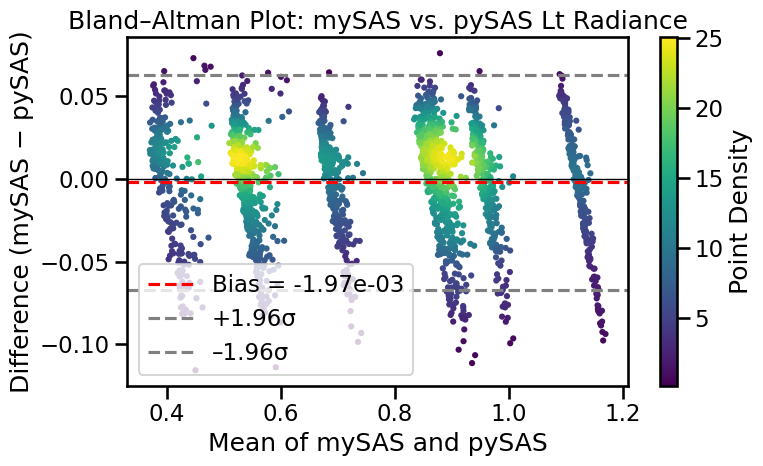

In [39]:
# Flatten all logger and pySAS values
logger_flat = merged_converted[[f'{wl}_converted' for wl in wavelengths]].to_numpy().flatten()
pysas_flat  = merged_converted[[f'{wl}_pySAS' for wl in wavelengths]].to_numpy().flatten()

# Mean and difference
mean_vals = (logger_flat + pysas_flat) / 2
diff_vals = logger_flat - pysas_flat

# Compute density
xy = np.vstack([mean_vals, diff_vals])
density = gaussian_kde(xy)(xy)

# Compute Bland–Altman stats
bias = np.mean(diff_vals)
loa = 1.96 * np.std(diff_vals)

# Plot
plt.figure(figsize=(8, 5))
sc = plt.scatter(mean_vals, diff_vals, c=density, cmap='viridis', s=20, edgecolor='none')
plt.axhline(bias, color='red', linestyle='--', label=f'Bias = {bias:.2e}')
plt.axhline(bias + loa, color='gray', linestyle='--', label='+1.96σ')
plt.axhline(bias - loa, color='gray', linestyle='--', label='–1.96σ')
plt.axhline(0, color='black', linewidth=1)

# Labels and style
plt.xlabel("Mean of mySAS and pySAS")
plt.ylabel("Difference (mySAS − pySAS)")
plt.title("Bland–Altman Plot: mySAS vs. pySAS Lt Radiance")
plt.colorbar(sc, label='Point Density')
plt.legend()
plt.tight_layout()

# Save and show
plt.savefig(os.path.join(output_dir,"Bland_Altman_Lt_ptDensity.png"), dpi=300, bbox_inches='tight')
plt.show()


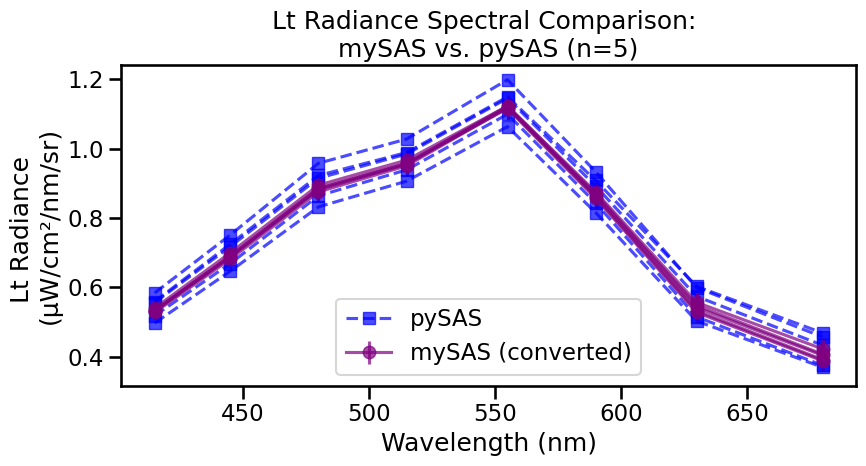

In [40]:
# Define wavelengths and column names
wavelengths = [415, 445, 480, 515, 555, 590, 630, 680]
logger_cols = [f'{wl}_converted' for wl in wavelengths]
pysas_cols  = [f'{wl}_pySAS' for wl in wavelengths]

# Get RMSE per wavelength from regression_results
rmse_map = {res['Wavelength']: res['RMSE'] for res in regression_results}
yerr = [rmse_map[wl] for wl in wavelengths]

# Sample 5 timepoints from the merged data
subset = merged_converted.sample(n=5, random_state=42)

# Plot
plt.figure(figsize=(9, 5))

for _, row in subset.iterrows():
    logger_vals = row[logger_cols].values
    pysas_vals  = row[pysas_cols].values

    # Logger with error bars
    plt.errorbar(wavelengths, logger_vals, yerr=yerr,
                 fmt='o-', color='purple', alpha=0.7, label='mySAS (converted)')

    # pySAS as dashed line
    plt.plot(wavelengths, pysas_vals, linestyle='--', marker='s',
             color='blue', alpha=0.7, label='pySAS')

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.xlabel("Wavelength (nm)")
plt.ylabel("Lt Radiance \n(µW/cm²/nm/sr)")
plt.title("Lt Radiance Spectral Comparison: \nmySAS vs. pySAS (n=5)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"mySAS_vs_pySAS_Lt_spectra.png"), dpi=300, bbox_inches='tight')
plt.show()
